# Assignment 4: Unsupervised Learning—Clustering and Recommendations
## Group 105
- Natasa Bolic (300241734)
- Brent Palmer (300193610)
## Imports

In [1]:
# imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import ast
import Levenshtein
import math
import re
from scipy.spatial import distance
from sklearn.cluster import MiniBatchKMeans

## Introduction

## Dataset Description

## Dataset Description

**Url:** https://www.kaggle.com/datasets/rounakbanik/the-movies-dataset <br>
**Name:** The Movies Dataset <br>
**Author:** The dataset was uploaded by Rounak Banik. The data was collected from the TMDB Open API and the Official GroupLens website. <br>
**Purpose:** The original purpose of the dataset was to learn about the history of cinema through EDA and to build various types of recommender systems for movies. Some suggested uses for the dataset are building models to predict movie revenue or success, and building content based and collaborative filtering based recommendation systems. <br>
**Shape:** The data we are using is separated into two files.
- `movies_metadata.csv`
    - There are 45466 rows and 24 columns. (45466, 24)
- `ratings_small.csv`
    - There are 100004 rows and 4 columns. (100004, 4)

**Features:**
- `movies_metadata.csv`
    - `adult` (categorical): Indicates (True/False) if the movie is rated as "Adults Only", meaning that the content is not suitable for minors.
    - `belongs_to_collection` (categorical): The movie series/collection that the movie belongs to, stored as a string representation of a dictionary that describes the series with keys 'id', 'name', 'poster_path' and 'backdrop_path'.
    - `budget` (numerical): The budget of the movie (in USD).
    - `genres` (categorical): The genres of the movie, stored as a string representation of a list where each item is a dictionary representing a genre with keys 'id' and 'name'.
    - `homepage` (categorical): The link to the official homepage of the movie.
    - `id` (categorical): The movie's ID.
    - `imdb_id` (categorical): The IMDB ID for the movie.
    - `original_language` (categorical): The original language of the movie, abbreviated to the two-letter format (i.e. the ISO 639-1 code).
    - `original_title` (categorical): The title of the movie in its original language.
    - `overview` (categorical): A short description of the movie.
    - `popularity` (numerical): The score assigned by TMBD to quantify the movie's popularity.
    - `poster_path` (categorical): The path segment of the URL to the poster image of the movie.
    - `production_companies` (categorical): The production companies that were involved with the production of the movie, stored as a string representation of a list where each item is a dictionary representing a company with keys 'id' and 'name'.
    - `production_countries` (categorical): The countries where the movie was made, stored as a string representation of a list where each item is a dictionary representing a country with keys 'iso_3166_1' (2-letter format) and 'name'.
    - `release_date` (categorical): The release date of the movie in the format YYYY-MM-DD.
    - `revenue` (numerical): The total revenue generated by the movie (in USD). 
    - `runtime` (numerical): The length of the movie (in minutes).
    - `spoken_languages` (categorical): The languages spoken in the movie, stored as a string representation of a list where each item is a dictionary representing a language with keys 'iso_639_1' (2-letter format) and 'name'.
    - `status` (categorical): The status of the movie, which is either released, rumored, planned, post production, or in production.
    - `tagline` (categorical): The movie's tagline.
    - `title` (categorical): The title of the movie in English.
    - `video` (categorical): Indicates (True/False) if the movie has an official video associated with it in the TMBD API.
    - `vote_average` (numerical): The average rating given to the movie by users.
    - `vote_count` (numerical): The number of users that rated the movie.
- `ratings_small.csv`
    - `userId` (categorical): The ID of the user that provided the rating.
    - `movieId` (categorical): The ID of the movie that was rated.
    - `rating` (numerical): The rating given to the movie by the user.
    - `timestamp` (categorical): The timestamp at which the rating was provided.

## Loading Data and Basic Exploration

### Loading Movies Metadata Dataset

In [2]:
# Read in the movies metadata dataset from a public repository
url = "https://raw.githubusercontent.com/BrentMRPalmer/CSI4142-A4/refs/heads/main/movies_metadata.csv"
metadata_df = pd.read_csv(url, low_memory=False)
metadata_df.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


In [3]:
metadata_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45466 entries, 0 to 45465
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   adult                  45466 non-null  object 
 1   belongs_to_collection  4494 non-null   object 
 2   budget                 45466 non-null  object 
 3   genres                 45466 non-null  object 
 4   homepage               7782 non-null   object 
 5   id                     45466 non-null  object 
 6   imdb_id                45449 non-null  object 
 7   original_language      45455 non-null  object 
 8   original_title         45466 non-null  object 
 9   overview               44512 non-null  object 
 10  popularity             45461 non-null  object 
 11  poster_path            45080 non-null  object 
 12  production_companies   45463 non-null  object 
 13  production_countries   45463 non-null  object 
 14  release_date           45379 non-null  object 
 15  re

In [4]:
metadata_df.shape

(45466, 24)

### Loading Ratings Small Dataset

In [5]:
# Read in the ratings small dataset from a public repository
url = "https://raw.githubusercontent.com/BrentMRPalmer/CSI4142-A4/refs/heads/main/ratings_small.csv"
ratings_df = pd.read_csv(url, low_memory=False)
ratings_df.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [6]:
ratings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100004 entries, 0 to 100003
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100004 non-null  int64  
 1   movieId    100004 non-null  int64  
 2   rating     100004 non-null  float64
 3   timestamp  100004 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


In [7]:
ratings_df.shape

(100004, 4)

## Data Preparation

To prepare the data, we use our validation techniques from Assignment 2 to clean the data and our EDA techniques from Assignment 1 to visualize the data.

There are two datasets to prepare, the first holding the metadata in `metadata_df`, and the second representing the user ratings in `ratings_df`. We perform the preparation on one dataset at a time.

### Cleaning and EDA of Metadata

We begin by cleaning and performing EDA on the metadata dataset.

#### Cleaning the Data

##### Validity Check 1: Exact Duplicates

We will first check for exact duplicates in the dataset, verifying that there are no rows that are identical over all columns.

**References:** <br>
Duplicated: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.duplicated.html <br>
Drop duplicates: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.drop_duplicates.html

In [8]:
# Exact duplicates check

# Apply the .duplicated method to the DataFrame to create a Series, with exact duplicates set to True
# keep=False will mark all duplicates as True (including the first and last occurrences)
duplicates = metadata_df.duplicated(keep=False)

# Print the number of rows that are exact duplicates
print(f"Number of duplicate rows: {duplicates.sum()}\n")

Number of duplicate rows: 33



Since there are 33 duplicate rows, let us further investigate the actual rows to determine how to handle them.

In [9]:
# Display the first 3 rows that are exact duplicates
print("Examples of three duplicate rows:")
metadata_df.loc[duplicates].head(3)

Examples of three duplicate rows:


,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
676,False,NaN,0,"[{'id': 18, 'name': 'Drama'}, {'id': 10749, 'n...",NaN,105045,tt0111613,de,Das Versprechen,"East-Berlin, 1961, shortly after the erection ...",...,1995-02-16,0.0,115.0,"[{'iso_639_1': 'de', 'name': 'Deutsch'}]",Released,"A love, a hope, a wall.",The Promise,False,5.0,1.0
1465,False,NaN,0,"[{'id': 18, 'name': 'Drama'}, {'id': 10749, 'n...",NaN,105045,tt0111613,de,Das Versprechen,"East-Berlin, 1961, shortly after the erection ...",...,1995-02-16,0.0,115.0,"[{'iso_639_1': 'de', 'name': 'Deutsch'}]",Released,"A love, a hope, a wall.",The Promise,False,5.0,1.0
7345,False,NaN,0,"[{'id': 80, 'name': 'Crime'}, {'id': 18, 'name...",NaN,5511,tt0062229,fr,Le Samouraï,Hitman Jef Costello is a perfectionist who alw...,...,1967-10-25,39481.0,105.0,"[{'iso_639_1': 'fr', 'name': 'Français'}]",Released,There is no solitude greater than that of the ...,Le Samouraï,False,7.9,187.0


As expected, the rows are exact duplicates. The movie `Das Versprechen` appears twice in the results above. We can safely remove the duplicates. We will store the results in a new DataFrame called `cleaned_metadata_df`. All subsequent cleaning will be done to the new DataFrame.

In [10]:
# Create a copy of the metadata DataFrame
cleaned_metadata_df = metadata_df.copy()

# Drop duplicates (retains first instance of a duplicated row)
cleaned_metadata_df = cleaned_metadata_df.drop_duplicates()

# verify no duplicates remain
duplicates = cleaned_metadata_df.duplicated(keep=False)

# Print the number of rows that are exact duplicates
print(f"Number of duplicate rows: {duplicates.sum()}\n")

Number of duplicate rows: 0



Since there are no remaining duplicate rows, the DataFrame has been successfully cleaned.

##### Validity Check 2: Data Type Check

Next, we will use the data type check to validate that the data stored is the correct data type. We will check the numerical features, which includes:
- `budget`: float
- `popularity`: float
- `revenue`: float
- `runtime`: float
- `vote_average`: float
- `vote_count`: float

We will first use our `method 1` from `Assignment 2`, which optimistically checks if the data is already stored as the correct data type. We specify a dictionary, where the keys are the features, and the values are the desired data types. We iterate over each feature in the dictionary, applying the data type check to each.

In [11]:
# Data type check

# Evalutes a single value's data type against the desired data type
def type_filter_method1(value, test_datatype):
    if pd.isna(value):
        return False
    return isinstance(value, test_datatype)

# Create a dictionary that maps each attribute to its correct datatype
data_type_dict = {
    "budget": float,
    "popularity": float,
    "revenue": float,
    "runtime": float,
    "vote_average": float,
    "vote_count": float
}

# Apply the function to every feature, setting rows whose value is not stored as the correct datatype to True
for feature in data_type_dict.keys():
    invalid_datatype = cleaned_metadata_df[feature].apply(
        lambda attribute: not type_filter_method1(attribute, data_type_dict[feature])
    )
    # Print the number of rows with a value that is not stored as the correct datatype for the designated attribute
    print(f"Number of rows where the {feature} value is not stored as the correct datatype ({data_type_dict[feature]}): {invalid_datatype.sum()}")

Number of rows where the budget value is not stored as the correct datatype (<class 'float'>): 45449
Number of rows where the popularity value is not stored as the correct datatype (<class 'float'>): 45449
Number of rows where the revenue value is not stored as the correct datatype (<class 'float'>): 6
Number of rows where the runtime value is not stored as the correct datatype (<class 'float'>): 263
Number of rows where the vote_average value is not stored as the correct datatype (<class 'float'>): 6
Number of rows where the vote_count value is not stored as the correct datatype (<class 'float'>): 6


Clearly, the optimistic approach of checking if the data is already stored as the correct datatype found that none of the features stored the data as the correct datatype. Many features are mostly correct, but none are perfect. We will now use our less optimistic `method 2` from `Assignment 2`, which checks if the data can be cast to the desired datatype. In some cases, the data could be perfectly fine, but it is just stored as a string instead of the desired type. Thus, `method 2` will uncover if the value of the underlying data is of the correct type.

In [12]:
# Evalutes a single value's data type against the desired data type
def type_filter_method2(value, test_datatype):
    if pd.isna(value):
        return False
    if test_datatype == int:
        try:
            value = float(value)
            return value % 1 == 0
        except Exception as e:
            return False
    else:
        try:
            value = test_datatype(value)
            return True
        except Exception as e:
            return False

# Apply the function to every feature, setting rows whose value is not stored as the correct datatype to True
for feature in data_type_dict.keys():
    invalid_datatype = cleaned_metadata_df[feature].apply(
        lambda attribute: not type_filter_method2(attribute, data_type_dict[feature])
    )
    # Print the number of rows with a value that is not stored as the correct datatype for the designated attribute
    print(f"Number of rows where the {feature} value is not stored as the correct datatype ({data_type_dict[feature]}): {invalid_datatype.sum()}")

Number of rows where the budget value is not stored as the correct datatype (<class 'float'>): 3
Number of rows where the popularity value is not stored as the correct datatype (<class 'float'>): 6
Number of rows where the revenue value is not stored as the correct datatype (<class 'float'>): 6
Number of rows where the runtime value is not stored as the correct datatype (<class 'float'>): 263
Number of rows where the vote_average value is not stored as the correct datatype (<class 'float'>): 6
Number of rows where the vote_count value is not stored as the correct datatype (<class 'float'>): 6


We find that for all features, the majority of values can be cast to the correct datatype. However, in all instances some values cannot be cast. We will now investigate each feature to determine the root cause. Having found the cause, we will find an appropriate method to handle the invalid cases. We first assess the `budget` feature, storing and printing examples of invalid rows to determine the issue.

In [13]:
# Apply the function to the budget feature, setting rows with values with an invalid data type to True
invalid_datatype = cleaned_metadata_df["budget"].apply(
    lambda attribute: not type_filter_method2(attribute, data_type_dict["budget"])
)

# Save the invalid rows
invalid_datatype_df = cleaned_metadata_df.loc[invalid_datatype]

# Print the number of rows where the test attribute value contains an incorrect datatype
print(f"Number of rows where the budget value's data type is not float: {invalid_datatype.sum()}\n")

# Display all rows where the test attribute value contains an incorrect datatype
print(f"All rows where the budget value's data type is not float:")
invalid_datatype_df.head(3)

Number of rows where the budget value's data type is not float: 3

All rows where the budget value's data type is not float:


,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
19730,- Written by Ørnås,0.065736,/ff9qCepilowshEtG2GYWwzt2bs4.jpg,"[{'name': 'Carousel Productions', 'id': 11176}...","[{'iso_3166_1': 'CA', 'name': 'Canada'}, {'iso...",1997-08-20,0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,...,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
29503,Rune Balot goes to a casino connected to the ...,1.931659,/zV8bHuSL6WXoD6FWogP9j4x80bL.jpg,"[{'name': 'Aniplex', 'id': 2883}, {'name': 'Go...","[{'iso_3166_1': 'US', 'name': 'United States o...",2012-09-29,0,68.0,"[{'iso_639_1': 'ja', 'name': '日本語'}]",Released,...,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
35587,Avalanche Sharks tells the story of a bikini ...,2.185485,/zaSf5OG7V8X8gqFvly88zDdRm46.jpg,"[{'name': 'Odyssey Media', 'id': 17161}, {'nam...","[{'iso_3166_1': 'CA', 'name': 'Canada'}]",2014-01-01,0,82.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,...,22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


These values are a complete type mismatch—it is clear that these are misplaced `.jpg` relative file paths. We choose to replace these values with `0`, since the dataset uses `0` to represent missing data in this category. In the process, we also cast all the values to numerics, since they are currently stored as strings. To convert the 3 incorrect cases to `0`, we simply use `errors="coerce"` to replace the values that cannot be cast with `NaN`, and `fillna(0)` to convert the new `NaN` values to `0`. We will verify that the cleaning worked for each feature after having first cleaned all features.

**References:** <br>
To Numeric: https://pandas.pydata.org/docs/reference/api/pandas.to_numeric.html <br>
Fillna: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.fillna.html

In [14]:
# Cast the values to numeric, and set errors to 0
cleaned_metadata_df["budget"] = pd.to_numeric(cleaned_metadata_df["budget"], errors="coerce").fillna(0)

Having cleaned `budget`, we move on to evaluating `popularity`. We use the same techniques used to assess `budget`.

In [15]:
# Apply the function to the popularity feature, setting rows with values with an invalid data type to True
invalid_datatype = cleaned_metadata_df["popularity"].apply(
    lambda attribute: not type_filter_method2(attribute, data_type_dict["popularity"])
)

# Save the invalid rows
invalid_datatype_df = cleaned_metadata_df.loc[invalid_datatype]

# Print the number of rows where the test attribute value contains an incorrect datatype
print(f"Number of rows where the popularity value's data type is not float: {invalid_datatype.sum()}\n")

# Display the invalid popularity values
print("The invalid popularity values are: ")
print(f"{invalid_datatype_df['popularity']}\n")

# Display the rows where the test attribute value contains an incorrect datatype
print(f"All rows where the popularity value's data type is not float:")
invalid_datatype_df.head(6)

Number of rows where the popularity value's data type is not float: 6

The invalid popularity values are: 
19729                      NaN
19730                      NaN
29502                      NaN
29503                      NaN
35586                      NaN
35587    Beware Of Frost Bites
Name: popularity, dtype: object

All rows where the popularity value's data type is not float:


,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
19729,False,NaN,0.0,"[{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...",NaN,82663,tt0113002,en,Midnight Man,British soldiers force a recently captured IRA...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19730,- Written by Ørnås,0.065736,0.0,"[{'name': 'Carousel Productions', 'id': 11176}...","[{'iso_3166_1': 'CA', 'name': 'Canada'}, {'iso...",1997-08-20,0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,...,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
29502,False,"{'id': 122661, 'name': 'Mardock Scramble Colle...",0.0,"[{'id': 16, 'name': 'Animation'}, {'id': 878, ...",http://m-scramble.jp/exhaust/,122662,tt2423504,ja,マルドゥック・スクランブル 排気,Third film of the Mardock Scramble series.,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
29503,Rune Balot goes to a casino connected to the ...,1.931659,0.0,"[{'name': 'Aniplex', 'id': 2883}, {'name': 'Go...","[{'iso_3166_1': 'US', 'name': 'United States o...",2012-09-29,0,68.0,"[{'iso_639_1': 'ja', 'name': '日本語'}]",Released,...,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
35586,False,NaN,0.0,"[{'id': 10770, 'name': 'TV Movie'}, {'id': 28,...",NaN,249260,tt2622826,en,Avalanche Sharks,A group of skiers are terrorized during spring...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
35587,Avalanche Sharks tells the story of a bikini ...,2.185485,0.0,"[{'name': 'Odyssey Media', 'id': 17161}, {'nam...","[{'iso_3166_1': 'CA', 'name': 'Canada'}]",2014-01-01,0,82.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,...,22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In five out of six cases, the `popularity` value is simply missing, and in the sixth case, the popularity value is clearly incorrect (`Beware of Frost Bites`). Observing the values of the other features, we note that this data is completely unusable. Most useful values are missing (`revenue`, `runtime`, `tagline`, `title`, etc.), and in many cases, those that are not missing are incorrect. Often, the feature's values are stored in the wrong feature; for example, the language is stored in the `original_title` in three cases. We reason that since the data for these rows is both inaccurate and incomplete, they provide no value to our study and should be removed using the listwise removal approach. Note that it is also only six rows, so this does not delete a significant amount of data. We also must cast the remaining values to numeric.

In [16]:
# Remove the invalid rows
cleaned_metadata_df = cleaned_metadata_df[~invalid_datatype]

# Cast the values to numeric
cleaned_metadata_df["popularity"] = pd.to_numeric(cleaned_metadata_df["popularity"], errors="coerce")

Having cleaned `popularity`, we move on to evaluating `revenue`. We use the same techniques used to assess `popularity`.

In [17]:
# Apply the function to the revenue feature, setting rows with values with an invalid data type to True
invalid_datatype = cleaned_metadata_df["revenue"].apply(
    lambda attribute: not type_filter_method2(attribute, data_type_dict["revenue"])
)

# Save the invalid rows
invalid_datatype_df = cleaned_metadata_df.loc[invalid_datatype]

# Print the number of rows where the test attribute value contains an incorrect datatype
print(f"Number of rows where the revenue value's data type is not float: {invalid_datatype.sum()}\n")

# Display the rows where the test attribute value contains an incorrect datatype
print(f"All rows where the revenue value's data type is not float:")
invalid_datatype_df.head(6)

Number of rows where the revenue value's data type is not float: 0

All rows where the revenue value's data type is not float:


,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count


We find that there are no values that cannot be cast to a float. This makes sense, as we observed that there were only six invalid rows for the `revenue` feature, and we removed six rows that had `NaN` values for `revenue` in the previous step. Thus, the invalid rows have already been removed. No cleaning is required for this feature, as `method 1` indicated the values are already floats. We move on to evaluating `runtime`. We use the same techniques used to assess `revenue`.

In [18]:
# Apply the function to the runtime feature, setting rows with values with an invalid data type to True
invalid_datatype = cleaned_metadata_df["runtime"].apply(
    lambda attribute: not type_filter_method2(attribute, data_type_dict["runtime"])
)

# Save the invalid rows
invalid_datatype_df = cleaned_metadata_df.loc[invalid_datatype]

# Print the number of rows where the test attribute value contains an incorrect datatype
print(f"Number of rows where the runtime value's data type is not float: {invalid_datatype.sum()}\n")

# Display the number of NaN runtime values
print(f"The number of NaN runtime values is: {invalid_datatype_df['runtime'].isna().sum()}\n")

# Display the rows where the test attribute value contains an incorrect datatype
print(f"Three rows where the runtime value's data type is not float:")
invalid_datatype_df.head(3)

Number of rows where the runtime value's data type is not float: 257

The number of NaN runtime values is: 257

Three rows where the runtime value's data type is not float:


,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
634,False,NaN,0.0,"[{'id': 35, 'name': 'Comedy'}]",NaN,287305,tt0117312,de,Peanuts – Die Bank zahlt alles,NaN,...,1996-03-21,0.0,NaN,[],Released,NaN,Peanuts – Die Bank zahlt alles,False,4.0,1.0
635,False,NaN,0.0,"[{'id': 35, 'name': 'Comedy'}]",NaN,339428,tt0116485,de,Happy Weekend,NaN,...,1996-03-14,65335.0,NaN,"[{'iso_639_1': 'de', 'name': 'Deutsch'}]",Released,NaN,Happy Weekend,False,0.0,0.0
644,False,NaN,0.0,"[{'id': 18, 'name': 'Drama'}]",NaN,278978,tt0118026,de,Und keiner weint mir nach,NaN,...,1996-02-29,0.0,NaN,"[{'iso_639_1': 'de', 'name': 'Deutsch'}]",Released,NaN,Und keiner weint mir nach,False,0.0,0.0


We find that there are `257` values that cannot be cast to float. We also note that they are all `NaN`, corresponding to missing values for the `runtime`. We observe that the rows contain otherwise valid data, so we do not perform listwise removal. Instead, we choose to impute the median value of the `runtime`. We believe median imputation is appropriate, as the `runtime` values are heavily clustered around the median, as visualized below.

**References:** <br>
Dropping a specific row: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.dropna.html <br>
Freedman-Diaconis: https://stats.stackexchange.com/questions/798/calculating-optimal-number-of-bins-in-a-histogram <br>
Gridlines: https://www.w3schools.com/python/matplotlib_grid.asp <br>
Histplot: https://seaborn.pydata.org/generated/seaborn.histplot.html <br>
Boxplot: https://seaborn.pydata.org/generated/seaborn.boxplot.html <br>
Median line: https://stackoverflow.com/questions/16180946/drawing-average-line-in-histogram <br>
Xlim: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.xlim.html

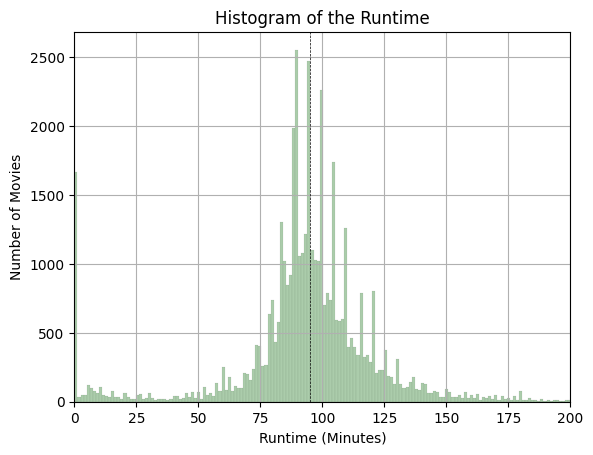

In [19]:
# Visualize the runtime distribution before imputation

no_na_runtime_df = cleaned_metadata_df.dropna(subset=['runtime'])

# Use Freedman-Diaconis rule to determine number of bins
x_axis = "runtime"
iqr = np.percentile(no_na_runtime_df[x_axis], 75) - np.percentile(no_na_runtime_df[x_axis], 25)
bin_width = 2 * iqr / (len(no_na_runtime_df[x_axis]) ** (1/3))
num_bins = int((no_na_runtime_df[x_axis].max() - no_na_runtime_df[x_axis].min()) / bin_width)

# Create the histogram of runtime
sns.histplot(data=no_na_runtime_df, x=x_axis, bins=num_bins, color="darkseagreen")

# Label the histogram
plt.xlabel(x_axis.title() + " (Minutes)")
plt.ylabel('Number of Movies')
plt.title('Histogram of the ' + x_axis.title())
plt.grid()
plt.axvline(no_na_runtime_df[x_axis].median(), color='k', linestyle='dashed', linewidth=0.5)
plt.xlim(0, 200)

# Display plot
plt.show()

In [20]:
# Save the median of the non-missing runtime values
runtime_median = cleaned_metadata_df.loc[cleaned_metadata_df['runtime'].notna(), 'runtime'].median()

# Replace the missing values with the median
cleaned_metadata_df.loc[invalid_datatype, "runtime"] = runtime_median

Having imputed the median `runtime` value to the missing values, we move on to evaluating `vote_average`. We use the same techniques used to assess `runtime`.

In [21]:
# Apply the function to the vote_average feature, setting rows with values with an invalid data type to True
invalid_datatype = cleaned_metadata_df["vote_average"].apply(
    lambda attribute: not type_filter_method2(attribute, data_type_dict["vote_average"])
)

# Save the invalid rows
invalid_datatype_df = cleaned_metadata_df.loc[invalid_datatype]

# Print the number of rows where the test attribute value contains an incorrect datatype
print(f"Number of rows where the vote_average value's data type is not float: {invalid_datatype.sum()}\n")

# Display the rows where the test attribute value contains an incorrect datatype
print(f"All rows where the vote_average value's data type is not float:")
invalid_datatype_df.head()

Number of rows where the vote_average value's data type is not float: 0

All rows where the vote_average value's data type is not float:


,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count


We find that there are no values that cannot be cast to a float. This makes sense, as we observed that there were only six invalid rows for the `vote_average` feature, and we removed six rows that had `NaN` values for `revenue` in the previous step. Thus, the invalid rows have already been removed. No cleaning is required for this feature, as `method 1` indicated the values are already floats. We move on to evaluating `vote_count`. We use the same techniques used to assess `vote_average`.

In [22]:
# Apply the function to the vote_count feature, setting rows with values with an invalid data type to True
invalid_datatype = cleaned_metadata_df["vote_count"].apply(
    lambda attribute: not type_filter_method2(attribute, data_type_dict["vote_count"])
)

# Save the invalid rows
invalid_datatype_df = cleaned_metadata_df.loc[invalid_datatype]

# Print the number of rows where the test attribute value contains an incorrect datatype
print(f"Number of rows where the vote_count value's data type is not float: {invalid_datatype.sum()}\n")

# Display the rows where the test attribute value contains an incorrect datatype
print(f"All rows where the vote_count value's data type is not float:")
invalid_datatype_df.head()

Number of rows where the vote_count value's data type is not float: 0

All rows where the vote_count value's data type is not float:


,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count


We find that there are no values that cannot be cast to a float. This makes sense, as we observed that there were only six invalid rows for the `vote_count` feature, and we removed six rows that had `NaN` values for `revenue` in the previous step. Thus, the invalid rows have already been removed. No cleaning is required for this feature, as `method 1` indicated the values are already floats. We move on to verifying that the cleaning steps worked, be rerunning `method 1` on all features.

In [23]:
# Apply the function to every feature, setting rows whose value is not stored as the correct datatype to True
for feature in data_type_dict.keys():
    invalid_datatype = cleaned_metadata_df[feature].apply(
        lambda attribute: not type_filter_method1(attribute, data_type_dict[feature])
    )
    # Print the number of rows with a value that is not stored as the correct datatype for the designated attribute
    print(f"Number of rows where the {feature} value is not stored as the correct datatype ({data_type_dict[feature]}): {invalid_datatype.sum()}")

Number of rows where the budget value is not stored as the correct datatype (<class 'float'>): 0
Number of rows where the popularity value is not stored as the correct datatype (<class 'float'>): 0
Number of rows where the revenue value is not stored as the correct datatype (<class 'float'>): 0
Number of rows where the runtime value is not stored as the correct datatype (<class 'float'>): 0
Number of rows where the vote_average value is not stored as the correct datatype (<class 'float'>): 0
Number of rows where the vote_count value is not stored as the correct datatype (<class 'float'>): 0


As no rows contain values that are not stored as the correct datatype, we have successfully cleaned our data.

##### Validity Check 3: Format Errors

In this check, we would typically run a regex against a specific feature to determine whether or not it is in the correct format. However, in this case, we do not need to run the format check for two of our three target features, as we know certain features are not in the desired format directly from the dataset description and visual inspection. Thus, we will skip ahead to formatting the two features that we are using that are not in the desired format. Specifically, the two features we will be immediately cleaning include:
- `genres`: The genres of the movie, stored as a string representation of a list where each item is a dictionary representing a genre with keys `id` and `name`.
    - For `Study 1`, we want the `genres` stored directly as a list of the names as the genres such that we can compute Jaccard similarity on them. The genre `id` provides no value and can be safely removed.
    - Original format example: `[{'id': 16, 'name': 'Animation'}, {'id': 10749, 'name': 'Romance'}]`
    - Desired format example: `["Animation", "Romance"]` 
- `production_companies`: The production companies that were involved with the production of the movie, stored as a string representation of a list where each item is a dictionary representing a company with keys `id` and `name`.
    - For `Study 1`, we want the `production_companies` stored directly as a list of the names as the production companies such that we can compute the Sorensen-Dice Index on them. The production company `id` provides no value and can be safely removed.
    - Original format example: `[{'name': 'Pixar Animation Studios', 'id': 3}, {'name': 'Warner Bros.', 'id': 6194}]`
    - Desired format example: `['Pixar Animation Studios', 'Warner Bros.']`

We follow our cleaning of `genres` and `production_companies` with a more traditional approach to the validity check, first checking the validity of the `release_date` feature using our validity check from `Assignment 2`, then cleaning the data if necessary. Specifically, we validate that the `release_date` is in the format `YYYY-MM-DD`.

We begin with cleaning the `genres` format. We will first demonstrate what the original `genres` values look like.

**References:** <br>
Literal eval: https://docs.python.org/3/library/ast.html#ast.literal_eval <br>
Capitalize: https://www.w3schools.com/python/ref_string_capitalize.asp

In [24]:
# Provide examples of original genres values
cleaned_metadata_df["genres"]

0        [{'id': 16, 'name': 'Animation'}, {'id': 35, '...
1        [{'id': 12, 'name': 'Adventure'}, {'id': 14, '...
2        [{'id': 10749, 'name': 'Romance'}, {'id': 35, ...
3        [{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...
4                           [{'id': 35, 'name': 'Comedy'}]
                               ...                        
45461    [{'id': 18, 'name': 'Drama'}, {'id': 10751, 'n...
45462                        [{'id': 18, 'name': 'Drama'}]
45463    [{'id': 28, 'name': 'Action'}, {'id': 18, 'nam...
45464                                                   []
45465                                                   []
Name: genres, Length: 45443, dtype: object

As described above, the `genres` are stored as a string which holds a list of dictionaries, where each dictionary represents a genre with keys `id` and `name`. We wish to extract the `name` from each genre. To do so, we create a function that takes the string and stores it as a list using `ast.literal_eval()`. Then, we can iterate over each genre and extract the name. We normalize the names using `lower()` and `capitalize()` to ensure consistent casing. We apply this function to each movie in the DataFrame, overwriting the old `genres` with the new list of extracted names.

In [25]:
# Extract the genres for a specific movie
def extract_genres(genres):
    # Convert from string to list
    genres = ast.literal_eval(genres)

    # Iterate over each genre, extracting the name
    for i in range(len(genres)):
        genres[i] = genres[i]["name"].lower().capitalize()
    return genres

# Apply the function to the genres attribute, updating the genres to the processed list
cleaned_metadata_df["genres"] = cleaned_metadata_df["genres"].apply(extract_genres)

# Check the cleaned results
print("Examples of the cleaned genres feature: ")
cleaned_metadata_df["genres"]

Examples of the cleaned genres feature: 


0         [Animation, Comedy, Family]
1        [Adventure, Fantasy, Family]
2                   [Romance, Comedy]
3            [Comedy, Drama, Romance]
4                            [Comedy]
                     ...             
45461                 [Drama, Family]
45462                         [Drama]
45463       [Action, Drama, Thriller]
45464                              []
45465                              []
Name: genres, Length: 45443, dtype: object

As desired, the `genres` names have been successfully extracted and stored in their correct format. We move on to cleaning the `production_companies` feature in a similar way. We will first demonstrate what the original `production_companies` values look like.

In [26]:
# Provide examples of original production companies values
cleaned_metadata_df["production_companies"]

0           [{'name': 'Pixar Animation Studios', 'id': 3}]
1        [{'name': 'TriStar Pictures', 'id': 559}, {'na...
2        [{'name': 'Warner Bros.', 'id': 6194}, {'name'...
3        [{'name': 'Twentieth Century Fox Film Corporat...
4        [{'name': 'Sandollar Productions', 'id': 5842}...
                               ...                        
45461                                                   []
45462               [{'name': 'Sine Olivia', 'id': 19653}]
45463    [{'name': 'American World Pictures', 'id': 6165}]
45464                 [{'name': 'Yermoliev', 'id': 88753}]
45465                                                   []
Name: production_companies, Length: 45443, dtype: object

As described above, the production companies are stored as a string which holds a list of dictionaries, where each dictionary represents a production company with keys `id` and `name`. We wish to extract the `name` from each production company. To do so, we iterate over each movie, sending their `production_companies` values to our `extract_companies` function. Our function returns `[]` if the value is missing. Then, we extract the list from the string using `ast.literal_eval()`. Finally, we can iterate over each production company and extract the name. We normalize the names using `lower()` and `capitalize()` to ensure consistent casing. We apply this function to each movie in the DataFrame, overwriting the old `production_companies` with the new list of extracted names.

In [27]:
# Extract the production companies for a specific movie
def extract_companies(companies):
    # Handle missing companies
    if companies == [] or pd.isna(companies): 
        return []
        
    # Convert from string to list
    companies = ast.literal_eval(companies)

    # Iterate over each company, extracting the name
    for i in range(len(companies)):
        companies[i] = companies[i]["name"].lower().capitalize()
    return companies

# Apply the function to the production companies attribute, updating the production companies to the processed list 
cleaned_metadata_df["production_companies"] = cleaned_metadata_df["production_companies"].apply(extract_companies)

# Check the cleaned results
print("Examples of the cleaned production companies feature: ")
cleaned_metadata_df["production_companies"]

Examples of the cleaned production companies feature: 


0                                [Pixar animation studios]
1        [Tristar pictures, Teitler film, Interscope co...
2                           [Warner bros., Lancaster gate]
3                 [Twentieth century fox film corporation]
4             [Sandollar productions, Touchstone pictures]
                               ...                        
45461                                                   []
45462                                        [Sine olivia]
45463                            [American world pictures]
45464                                          [Yermoliev]
45465                                                   []
Name: production_companies, Length: 45443, dtype: object

As desired, the `production_companies` names have been successfully extracted and stored in their correct format. We now move on to checking the validity of `release_date` using our validity checker from `Assignment 2`. We verify the `release_date` is in the format `YYYY-MM-DD`.

In [28]:
# Format check

# Test attribute
test_attribute = "release_date"

# We will fix the regex for the release_date format (YYYY-MM-DD)
format_regex = r"^\d{4}-\d{2}-\d{2}$"

# Evaluates a single value against a given regex format
def format_filter(value, format_regex):
    return False if not isinstance(value, str) else bool(re.findall(format_regex, value))

# Apply the function to the test attribute, setting invalid formats to True
invalid_format = cleaned_metadata_df[test_attribute].apply(
    lambda attribute: not format_filter(attribute, format_regex)
)

# Save the invalid rows
invalid_format_df = cleaned_metadata_df.loc[invalid_format]

# Print the number of rows with invalid formatting on the chosen test attribute
print(f"Number of rows where the {test_attribute} value has an invalid format: {invalid_format.sum()}\n")

# Display the first 3 rows with invalid formatting on the chosen test attribute
print(f"Examples of three rows where the {test_attribute} value has an invalid format:")
invalid_format_df.head(3)

Number of rows where the release_date value has an invalid format: 84

Examples of three rows where the release_date value has an invalid format:


,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
711,False,NaN,0.0,[],NaN,365371,tt0114894,en,War Stories Our Mother Never Told Us,Seven New Zealand women speak about their live...,...,NaN,0.0,95.0,[],Released,NaN,War Stories Our Mother Never Told Us,False,0.0,0.0
734,False,NaN,0.0,[],NaN,215107,tt0105737,en,Vermont Is for Lovers,Vermont is for Lovers is an independently prod...,...,NaN,0.0,88.0,[],Released,NaN,Vermont Is for Lovers,False,0.0,0.0
3460,False,NaN,0.0,[Drama],NaN,94214,tt0210130,en,"Jails, Hospitals & Hip-Hop","Jails, Hospitals &amp; Hip-Hop is a cinematic ...",...,NaN,10.0,90.0,[],NaN,three worlds / two million voices / one genera...,"Jails, Hospitals & Hip-Hop",False,0.0,0.0


We note that there are 84 rows with an invalid `release_date` format. However, we also note that the provided examples are all simply missing a `release_date` value. We verify that all 84 incorrectly formatted `release_date` values are in fact just missing values.

In [29]:
cleaned_metadata_df["release_date"].isna().sum()

84

As expected, the 84 values with an incorrect format are simply just missing values. All of the present values are in the correct format. We choose to leave the missing values as `NaN` is adequately representative in this context. The other data in the rows appears present and usable, thus we do not believe it makes sense to perform listwise removal. We will bear this missing data in mind, and if we choose to use this feature in a study we may choose to perform pairwise deletion prior to the study (simply omit the rows without a `release_date` value from that particular study).

Thus, we have now completed our cleaning for the format check.

##### Validity Check 4: Presence Errors

We now check for presence errors, validating that values are not missing in the designated columns. We check for the six numeric features, as missing values could be problematic for clustering in `Study 2`. Specifically, the features we are checking includes:
- `budget`
- `popularity`
- `revenue`
- `runtime`
- `vote_average`
- `vote_count`

In [30]:
# Presence check

# Selected features
selected_features = ["budget", "popularity", "revenue", "runtime", "vote_average", "vote_count"]

# Iterate over each column and perform the presence check on each
for column in selected_features:
    # Apply pd.isna() to the test attribute, setting rows with missing values in the designated column to True
    invalid_presence = cleaned_metadata_df[column].apply(pd.isna)

    # Print the number of rows with a missing value in the chosen test attribute
    print(f"Number of rows where the {column} value is missing: {invalid_presence.sum()}")

Number of rows where the budget value is missing: 0
Number of rows where the popularity value is missing: 0
Number of rows where the revenue value is missing: 0
Number of rows where the runtime value is missing: 0
Number of rows where the vote_average value is missing: 0
Number of rows where the vote_count value is missing: 0


We note that at first glance, there are no missing values in the numeric features. However, we had previously observed that the dataset appears to use `0` to represent missing data for numeric features. Thus, we will check the number of occurrences of `0` in each numeric feature as an extended presence check. Note that for many features, like `budget`, `runtime`, and `revenue`, a value of `0` does not make sense and must indicate a missing value.

In [31]:
# Iterate over each column and perform the presence check on each
for column in selected_features:
    # Check if the value of the selected feature is 0, setting rows with missing values in the designated column to True
    invalid_presence = cleaned_metadata_df[column] == 0

    # Print the number of rows with a missing value in the chosen test attribute
    print(f"Number of rows where the {column} value is missing: {invalid_presence.sum()}")

Number of rows where the budget value is missing: 36554
Number of rows where the popularity value is missing: 66
Number of rows where the revenue value is missing: 38038
Number of rows where the runtime value is missing: 1558
Number of rows where the vote_average value is missing: 2996
Number of rows where the vote_count value is missing: 2897


As expected, there in fact are a reasonably high number of missing values. However, in many of these cases, the rest of the data in the rows is perfect valid. It does not make sense to perform listwise deletion. We choose to perform **pairwise deletion** in `Study 2` where it makes sense, depending on which features we decide to use. The pairwise deletion will be performed in a copy of the DataFrame immediately before the analysis, to ensure that no data is lost for other studies. In some cases, a value of `0` is actually meaningful, for example `vote_count`.

##### Validity Check 5: Uniqueness Errors

We conclude our validity checks with a check for uniqueness. Specifically, we run our uniqueness check from `Assignment 2` to validate that the `imdb_id` values are unique. This is a good way to verify that there are not duplicate movies.

In [32]:
# Uniqueness check

# Attribute selection
test_attribute = "imdb_id"

# Note that we do not want to classify movies with a missing imdb_id as duplicates
no_na_imdb_id_df = cleaned_metadata_df.dropna(subset=['imdb_id'])

# Apply the function to the test attribute, setting rows with non-unique values in the designated column to True
invalid_uniqueness = no_na_imdb_id_df.duplicated(keep=False, subset=[test_attribute])

# Print the number of rows with a value that is not unique in the chosen column
print(f"Number of rows where the {test_attribute} value is not unique: {invalid_uniqueness.sum()}\n")

# Save the invalid rows
invalid_datatype_df = no_na_imdb_id_df.loc[invalid_uniqueness]

# Display the first 6 rows where the test attribute value is not unique
print(f"Examples of six rows where the {test_attribute} value is not unique:")
invalid_datatype_df.sort_values(test_attribute).head(6)

Number of rows where the imdb_id value is not unique: 26

Examples of six rows where the imdb_id value is not unique:


,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
949,False,NaN,4.0,"[Drama, Romance, War]",NaN,22649,tt0022879,en,A Farewell to Arms,British nurse Catherine Barkley (Helen Hayes) ...,...,1932-12-08,25.0,89.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Every woman who has loved will understand,A Farewell to Arms,False,6.2,29.0
15074,False,NaN,4.0,"[Drama, Romance, War]",NaN,22649,tt0022879,en,A Farewell to Arms,British nurse Catherine Barkley (Helen Hayes) ...,...,1932-12-08,25.0,89.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Every woman who has loved will understand,A Farewell to Arms,False,6.2,29.0
838,False,NaN,0.0,[Drama],NaN,132641,tt0046468,ja,Tsuma,"Ten years into a marriage, the wife is disappo...",...,1953-04-29,0.0,89.0,"[{'iso_639_1': 'ja', 'name': '日本語'}]",Released,NaN,Wife,False,0.0,0.0
30001,False,NaN,0.0,[Drama],NaN,132641,tt0046468,ja,Tsuma,"Ten years into a marriage, the wife is disappo...",...,1953-04-29,0.0,89.0,"[{'iso_639_1': 'ja', 'name': '日本語'}]",Released,NaN,Wife,False,0.0,0.0
5710,False,NaN,0.0,[Drama],NaN,109962,tt0082992,en,Rich and Famous,Two literary women compete for 20 years: one w...,...,1981-09-23,0.0,115.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,"From the very beginning, they knew they'd be f...",Rich and Famous,False,4.9,7.0
20899,False,NaN,0.0,[Drama],NaN,109962,tt0082992,en,Rich and Famous,Two literary women compete for 20 years: one w...,...,1981-09-23,0.0,115.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,"From the very beginning, they knew they'd be f...",Rich and Famous,False,4.9,7.0


It is clear that these are duplicates, and only one copy of each needs to be saved. We remove the duplicates below. Note that we do not want to remove rows with `NaN`, so we first save them in a separate DataFrame. We delete the duplicates in a DataFrame without the `NaN` values, and then we add the `NaN` values back in.

**References:** <br>
Concat: https://pandas.pydata.org/docs/reference/api/pandas.concat.html

In [33]:
# Split the NaN rows from the non-NaN rows
na_imdb_id_df = cleaned_metadata_df.loc[cleaned_metadata_df["imdb_id"].isna()]

# Drop duplicates (retains first instance of a duplicated row)
no_na_imdb_id_df = no_na_imdb_id_df.drop_duplicates(subset=["imdb_id"])

# Merge the no_na DF with the na DF
cleaned_metadata_df = pd.concat([no_na_imdb_id_df, na_imdb_id_df])

We have now deleted the rows with duplicate `imdb_id` values. We verify that the rows have been duplicated.

In [34]:
# Note that we do not want to classify movies with a missing imdb_id as duplicates
no_na_imdb_id_df = cleaned_metadata_df.dropna(subset=['imdb_id'])

# Apply the function to the test attribute, setting rows with non-unique values in the designated column to True
invalid_uniqueness = no_na_imdb_id_df.duplicated(keep=False, subset=[test_attribute])

# Print the number of rows with a value that is not unique in the chosen column
print(f"Number of rows where the {test_attribute} value is not unique: {invalid_uniqueness.sum()}\n")

# Save the invalid rows
invalid_datatype_df = no_na_imdb_id_df.loc[invalid_uniqueness]

# Display the first 10 rows where the test attribute value is not unique
print(f"Examples of ten rows where the {test_attribute} value is not unique:")
invalid_datatype_df.sort_values(test_attribute).head(10)

Number of rows where the imdb_id value is not unique: 0

Examples of ten rows where the imdb_id value is not unique:


,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count


Thus, we have successfully cleaned for uniqueness on the `imdb_id` attribute. This concludes our data cleaning section for the metadata DataFrame.

#### Exploratory Data Analysis (EDA)

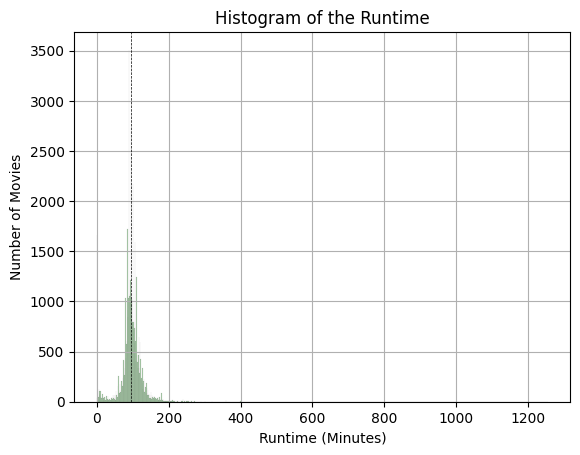

In [35]:
# Visualize the runtime distribution

# Use Freedman-Diaconis rule to determine number of bins
x_axis = "runtime"
iqr = np.percentile(cleaned_metadata_df[x_axis], 75) - np.percentile(cleaned_metadata_df[x_axis], 25)
bin_width = 2 * iqr / (len(cleaned_metadata_df[x_axis]) ** (1/3))
num_bins = int((cleaned_metadata_df[x_axis].max() - cleaned_metadata_df[x_axis].min()) / bin_width)

# Create the histogram of runtime
sns.histplot(data=cleaned_metadata_df, x=x_axis, bins=num_bins, color="darkseagreen")

# Label the histogram
plt.xlabel(x_axis.title() + " (Minutes)")
plt.ylabel('Number of Movies')
plt.title('Histogram of the ' + x_axis.title())
plt.grid()
plt.axvline(cleaned_metadata_df[x_axis].median(), color='k', linestyle='dashed', linewidth=0.5)

# Display plot
plt.show()

In [36]:
# features = ["budget", "popularity", "revenue", "runtime", "vote_average", "vote_count"]

# for feature in features:
#     for feature2 in features:
#         if feature == feature2:
#             continue
#         # Save a DataFrame with the two desired features
#         feature1 = feature
#         feature2 = feature2
#         revenue_budget_metadata_df = cleaned_metadata_df[[feature1, feature2]]
        
#         # Drop all rows with missing data
#         revenue_budget_metadata_df = revenue_budget_metadata_df.loc[~((revenue_budget_metadata_df[feature1] == 0) | (revenue_budget_metadata_df[feature2] == 0))]
        
#         # Verify the updated DataFrame looks appropriate
#         revenue_budget_metadata_df.head()

#         plt.scatter(revenue_budget_metadata_df[feature1], revenue_budget_metadata_df[feature2])
#         plt.xlabel(feature1)
#         plt.ylabel(feature2)
#         plt.show()

### Cleaning and EDA of Ratings

We now perform cleaning and EDA on the ratings dataset.

#### Cleaning the Data

Note that we will reuse the defined functions in the metadata cleaning section.

##### Validity Check 1: Exact Duplicates

We will first check for exact duplicates in the dataset, verifying that there are no rows that are identical over all columns.

In [37]:
# Exact duplicates check

# Apply the .duplicated method to the DataFrame to create a Series, with exact duplicates set to True
# keep=False will mark all duplicates as True (including the first and last occurrences)
duplicates = ratings_df.duplicated(keep=False)

# Print the number of rows that are exact duplicates
print(f"Number of duplicate rows: {duplicates.sum()}\n")

Number of duplicate rows: 0



Since there are no duplicate rows, no cleaning is required.

#### Exploratory Data Analysis (EDA)

## Studies

### Study 1 — Similarity Measures

[desc]

#### Similarity Measure 1 — Jaccard Distance on Genres

[desc]

**References:** <br>
Similarity Overview: https://medium.com/@jodancker/a-brief-introduction-to-distance-measures-ac89cbd2298 <br>
Jaccard: https://stackoverflow.com/questions/46975929/how-can-i-calculate-the-jaccard-similarity-of-two-lists-containing-strings-in-py <br>
Sets: https://docs.python.org/3/tutorial/datastructures.html <br>
To List: https://pandas.pydata.org/docs/reference/api/pandas.Series.to_list.html <br>
Select columns: https://pandas.pydata.org/docs/getting_started/intro_tutorials/03_subset_data.html <br>
Select specific rows: https://stackoverflow.com/questions/46380075/pandas-select-n-middle-rows <br>
Sort by feature: https://realpython.com/pandas-sort-python/

In [38]:
# Similarity measure 1 — Jaccard distance on Genres

# Select the reference movie
reference_movie = "Se7en"

def jaccard_similarity(list1, list2):
    # Convert the lists into sets
    set1 = set(list1)
    set2 = set(list2)

    # Find the size of the intersection
    intersection_size = len(set1 & set2)

    # Find the size of the union
    union_size = len(set1 | set2)

    # Handle empty case
    if union_size == 0:
        return 1

    # Compute and return jaccard distance
    return 1 - (intersection_size/union_size)

# Store the genres for the reference movie
reference_genres = cleaned_metadata_df[cleaned_metadata_df["original_title"]==reference_movie]["genres"].to_list()[0]

# Apply the function to the genres attribute, computing the Jaccard distance between the genres of the reference movie with every other movie
new_feature_name = "jaccard_genre_distance_to_" + reference_movie
cleaned_metadata_df[new_feature_name] = cleaned_metadata_df["genres"].apply(
    lambda genres: jaccard_similarity(reference_genres, genres)
)

# Print the genres of the reference movie
print(f"The genres of {reference_movie}: {reference_genres}\n")

# Print the five example rows
print(f"Examples of five rows with Jaccard distance to {reference_movie} based on the movie genres:")
cleaned_metadata_df[["original_title", "genres", new_feature_name]].head(10).tail(5)

The genres of Se7en: ['Crime', 'Mystery', 'Thriller']

Examples of five rows with Jaccard distance to Se7en based on the movie genres:


,original_title,genres,jaccard_genre_distance_to_Se7en
5,Heat,"[Action, Crime, Drama, Thriller]",0.6
6,Sabrina,"[Comedy, Romance]",1.0
7,Tom and Huck,"[Action, Adventure, Drama, Family]",1.0
8,Sudden Death,"[Action, Adventure, Thriller]",0.8
9,GoldenEye,"[Adventure, Action, Thriller]",0.8


[desc]

In [39]:
# Request: Show me the top 10 movies with the most similar genres as the reference movie
cleaned_metadata_df.loc[cleaned_metadata_df["original_title"] != reference_movie, ["original_title", "genres", new_feature_name]].sort_values(new_feature_name).head(10)

,original_title,genres,jaccard_genre_distance_to_Se7en
13193,La Chambre des morts,"[Mystery, Thriller, Crime]",0.0
12065,Eastern Promises,"[Thriller, Crime, Mystery]",0.0
23831,The Mystery of the 13th Guest,"[Thriller, Crime, Mystery]",0.0
29454,Beck 30 - Sjukhusmorden,"[Thriller, Crime, Mystery]",0.0
4051,The Mirror Crack'd,"[Crime, Thriller, Mystery]",0.0
4755,Domestic Disturbance,"[Mystery, Thriller, Crime]",0.0
8741,"Farewell, My Lovely","[Crime, Mystery, Thriller]",0.0
41711,"Kiss Me, Kill Me","[Mystery, Crime, Thriller]",0.0
33752,심야의 FM,"[Thriller, Crime, Mystery]",0.0
33576,The Boy Next Door,"[Crime, Mystery, Thriller]",0.0


[desc]

#### Similarity Measure 2 — Edit Distance on Title

[desc]

**References:** <br>
Levenshtein Distance: https://www.geeksforgeeks.org/introduction-to-python-levenshtein-module/ <br>

In [40]:
# Similarity Measure 2 — Edit Distance on Title

# Store the title used to compute the edit distance
reference_title = "Back to the Future"

# Apply the Levenshtein.distance function from the Levenshtein library to compute the edit distance between the reference title and the title of every other movie
new_feature_name = "edit_distance_title_to" + reference_title
cleaned_metadata_df[new_feature_name] = cleaned_metadata_df["original_title"].apply(
    lambda title: Levenshtein.distance(reference_title, title)
)

# Print the reference title
print(f"The reference title: {reference_title}\n")

# Print five example rows
print(f"Examples of five rows with edit distance to {reference_title} based on the movie title:")
cleaned_metadata_df[["original_title", new_feature_name]].head(5)

The reference title: Back to the Future

Examples of five rows with edit distance to Back to the Future based on the movie title:


,original_title,edit_distance_title_toBack to the Future
0,Toy Story,14
1,Jumanji,18
2,Grumpier Old Men,17
3,Waiting to Exhale,13
4,Father of the Bride Part II,19


[desc]

In [41]:
# Request: Show me the top 10 movies with a similar title to the reference movie
cleaned_metadata_df.loc[cleaned_metadata_df["original_title"] != reference_title, ["original_title", new_feature_name]].sort_values(new_feature_name).head(11).tail(10)

,original_title,edit_distance_title_toBack to the Future
21860,Back in the Saddle,7
30979,Back to the Jurassic,7
23537,Maps to the Stars,7
43818,Back to You and Me,8
39554,Back in the Day,8
23550,Back in the Day,8
37449,Back To The Sea,8
24299,Crimes of the Future,8
1902,Back to the Future Part II,8
21531,The Lost Future,8


[desc]

#### Similarity Measure 3 — Euclidean Distance on Revenue

[desc]

**References:** <br>
Euclidean Distance: https://www.w3schools.com/python/ref_math_dist.asp <br>

In [42]:
# Similarity Measure 3 — Euclidean Distance on Revenue

# Select the reference movie
reference_movie = "Pulp Fiction"

# Store the revenue for the reference movie
reference_revenue =  float(cleaned_metadata_df[cleaned_metadata_df["original_title"]==reference_movie]["revenue"].iloc[0])

# Apply the math.dist() function from the math library to compute the Euclidean distance between the revenue of the reference movie and the revenue of every other movie
new_feature_name = "euclidean_distance_revenue_to_" + reference_movie
cleaned_metadata_df[new_feature_name] = cleaned_metadata_df["revenue"].apply(
    lambda revenue: math.dist([reference_revenue], [revenue])
)

# Print the revenue of the reference movie
print(f"The revenue of {reference_movie}: {reference_revenue}\n")

# Print five example rows
print(f"Examples of five rows with Euclidean distance to {reference_movie} based on the movie revenue:")
cleaned_metadata_df[["original_title", "revenue", new_feature_name]].head(20).tail(5)

The revenue of Pulp Fiction: 213928762.0

Examples of five rows with Euclidean distance to Pulp Fiction based on the movie revenue:


,original_title,revenue,euclidean_distance_revenue_to_Pulp Fiction
15,Casino,116112375.0,97816387.0
16,Sense and Sensibility,135000000.0,78928762.0
17,Four Rooms,4300000.0,209628762.0
18,Ace Ventura: When Nature Calls,212385533.0,1543229.0
19,Money Train,35431113.0,178497649.0


[desc]

In [43]:
# Request: Show me the top 10 movies with a similar revenue to the reference movie
cleaned_metadata_df.loc[cleaned_metadata_df["original_title"] != reference_movie, ["original_title", "revenue", new_feature_name]].sort_values(new_feature_name).head(10)

,original_title,revenue,euclidean_distance_revenue_to_Pulp Fiction
1056,Dirty Dancing,213954274.0,25512.0
221,Disclosure,214015089.0,86327.0
5284,The Bourne Identity,214034224.0,105462.0
13847,Public Enemies,214104620.0,175858.0
3871,卧虎藏龙,213525736.0,403026.0
16818,Just Go with It,214918407.0,989645.0
25503,Into the Woods,212902372.0,1026390.0
13241,Bedtime Stories,212874442.0,1054320.0
5672,8 Mile,215000000.0,1071238.0
15483,The Sorcerer's Apprentice,215283742.0,1354980.0


[desc

#### Similarity Measure 4 — Manhattan Distance on Budget

[desc]

**References:** <br>
Manhattan Distance: https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.cityblock.html <br>

In [44]:
# Similarity Measure 4 — Manhattan Distance on Budget

# Select the reference movie
reference_movie = "Interstellar"

# Store the budget for the reference movie
reference_budget =  float(cleaned_metadata_df[cleaned_metadata_df["original_title"]==reference_movie]["budget"].iloc[0])

# Apply the distance.cityblock() function from the scipy library to compute the Manhattan distance between the budget of the reference movie and the budget of every other movie
new_feature_name = "manhattan_distance_budget_to_" + reference_movie
cleaned_metadata_df[new_feature_name] = cleaned_metadata_df["budget"].apply(
    lambda budget: distance.cityblock([reference_budget], [budget])
)

# Print the budget of the reference movie
print(f"The budget of {reference_movie}: {reference_budget}\n")

# Print five example rows
print(f"Examples of five rows with Manhattan distance to {reference_movie} based on the movie budget:")
cleaned_metadata_df[["original_title", "budget", new_feature_name]].head(20).tail(5)

The budget of Interstellar: 165000000.0

Examples of five rows with Manhattan distance to Interstellar based on the movie budget:


,original_title,budget,manhattan_distance_budget_to_Interstellar
15,Casino,52000000.0,113000000.0
16,Sense and Sensibility,16500000.0,148500000.0
17,Four Rooms,4000000.0,161000000.0
18,Ace Ventura: When Nature Calls,30000000.0,135000000.0
19,Money Train,60000000.0,105000000.0


[desc]

In [45]:
# Request: Show me the top 10 movies with a similar budget to the reference movie
cleaned_metadata_df.loc[cleaned_metadata_df["original_title"] != reference_movie, ["original_title", "budget", new_feature_name]].sort_values(new_feature_name).head(10)

,original_title,budget,manhattan_distance_budget_to_Interstellar
8238,The Polar Express,165000000.0,0.0
30556,Independence Day: Resurgence,165000000.0,0.0
24455,Big Hero 6,165000000.0,0.0
15372,Shrek Forever After,165000000.0,0.0
19726,Wreck-It Ralph,165000000.0,0.0
26568,Doctor Strange,165000000.0,0.0
14984,How to Train Your Dragon,165000000.0,0.0
16492,Cowboys & Aliens,163000000.0,2000000.0
21941,Thor: The Dark World,170000000.0,5000000.0
23360,Godzilla,160000000.0,5000000.0


[desc]

#### Similarity Measure 5 — Sorensen-Dice Index on Production Companies

[desc]

**References:** <br>
Sorensen-Dice Index: https://medium.com/@jodancker/a-brief-introduction-to-distance-measures-ac89cbd2298

In [46]:
# Similarity Measure 5 — Sorensen-Dice Index on Production Companies

# Select the reference movie
reference_movie = "Big Hero 6"

def sorensen_dice_index(list1, list2):
    # Convert the lists into sets
    set1 = set(list1)
    set2 = set(list2)

    # Handle empty case
    if len(set1 | set2) == 0:
        return 1

    # Find the size of the intersection
    intersection_size = len(set1 & set2)

    # Find the size of set 1
    set1_size = len(set1)

    # Find the size of set 2
    set2_size = len(set2)

    return (2 * intersection_size) / (set1_size + set2_size)

# Store the production companies for the reference movie
reference_production_companies = cleaned_metadata_df[cleaned_metadata_df["original_title"]==reference_movie]["production_companies"].to_list()[0]

# Apply the function to the production companies attribute, computing the Sorensen Dice Index between the production companies of the reference movie with every other movie
new_feature_name = "sorensen_dice_index_with_" + reference_movie
cleaned_metadata_df[new_feature_name] = cleaned_metadata_df["production_companies"].apply(
    lambda production_companies: sorensen_dice_index(reference_production_companies, production_companies)
)

# Print the production companies of the reference movie
print(f"The production companies of {reference_movie}: {reference_production_companies}\n")

# Print the five example rows
print(f"Examples of five rows with sorensen dice index to {reference_movie} based on the movie production companies:")
cleaned_metadata_df[["original_title", "production_companies", new_feature_name]].head(10).tail(5)

The production companies of Big Hero 6: ['Walt disney pictures', 'Walt disney animation studios']

Examples of five rows with sorensen dice index to Big Hero 6 based on the movie production companies:


,original_title,production_companies,sorensen_dice_index_with_Big Hero 6
5,Heat,"[Regency enterprises, Forward pass, Warner bros.]",0.000000
6,Sabrina,"[Paramount pictures, Scott rudin productions, ...",0.000000
7,Tom and Huck,[Walt disney pictures],0.666667
8,Sudden Death,"[Universal pictures, Imperial entertainment, S...",0.000000
9,GoldenEye,"[United artists, Eon productions]",0.000000


[desc] - mention how this is the only similarity one, so we use descending instead of ascending

In [47]:
# Request: Show me the top 10 movies with the same production companies as the reference movie
cleaned_metadata_df.loc[cleaned_metadata_df["original_title"] != reference_movie, ["original_title", "production_companies", new_feature_name]].sort_values(new_feature_name, ascending=False).head(10)

,original_title,production_companies,sorensen_dice_index_with_Big Hero 6
31658,Feast,"[Walt disney pictures, Walt disney animation s...",1.0
40457,How to Hook Up Your Home Theater,"[Walt disney pictures, Walt disney animation s...",1.0
22110,Frozen,"[Walt disney pictures, Walt disney animation s...",1.0
21419,Planes,"[Walt disney pictures, Walt disney animation s...",1.0
36253,Zootopia,"[Walt disney pictures, Walt disney animation s...",1.0
19901,Paperman,"[Walt disney pictures, Walt disney animation s...",1.0
14496,The Princess and the Frog,"[Walt disney pictures, Walt disney animation s...",1.0
26089,Get a Horse!,"[Walt disney pictures, Walt disney animation s...",1.0
18830,The Ballad of Nessie,"[Walt disney pictures, Walt disney animation s...",1.0
41457,Moana,"[Walt disney pictures, Walt disney animation s...",1.0


[desc]

### Study 2 — Clustering Algorithms

**References:** <br>
Dropping missing data: https://www.statology.org/pandas-drop-rows-based-on-multiple-conditions/ <br>
KMeans tutorial: https://ai.plainenglish.io/performing-k-means-clustering-with-python-and-scikit-learn-f2f833841f69 <br>
KMeans documentation: https://scikit-learn.org/stable/modules/generated/sklearn.cluster.MiniBatchKMeans.html <br>
Colours from labels: https://datascience.stackexchange.com/questions/122510/plot-clustered-data-by-kmeans-with-colors-for-clusters-and-shapes-for-external-l

In [122]:
def run_and_plot_minibatchkmeans(input_df, k_values, feature1, feature2):
    for k in k_values:
        # Fit MiniBatchKMeans with Scikit
        minibatchkmeans = MiniBatchKMeans(init='k-means++', n_clusters=k, n_init="auto", random_state=0)
        minibatchkmeans.fit(revenue_budget_metadata_df)
        
        # Predict the cluster for all movies
        P = minibatchkmeans.predict(revenue_budget_metadata_df)

        # Get the cluster labels for each data point, to be used for colours
        labels = minibatchkmeans.labels_
        
        # Generate scatter plot for training data
        colors = list(map(lambda x: '#3b4cc0' if x == 1 else '#b40426', P))
        plt.scatter(revenue_budget_metadata_df[feature1[0]], revenue_budget_metadata_df[feature2[0]], c=labels, marker="o", picker=True)
        plt.title(str(k) + ' Clusters of Data (' + feature1[0].title() + " vs " + feature2[0].title() + ")")
        plt.xlabel(feature1[0].title() + " (" + feature1[1] + ")")
        plt.ylabel(feature2[0].title() + " (" + feature2[1] + ")")
        plt.show()

In [115]:
# Save a DataFrame with the two desired features
feature1 = "budget"
feature2 = "runtime"
revenue_budget_metadata_df = cleaned_metadata_df[[feature1, feature2]]

# Drop all rows with missing data
revenue_budget_metadata_df = revenue_budget_metadata_df.loc[~((revenue_budget_metadata_df[feature1] == 0) | (revenue_budget_metadata_df[feature2] == 0))]

# Verify the updated DataFrame looks appropriate
revenue_budget_metadata_df["budget"].min()

1.0

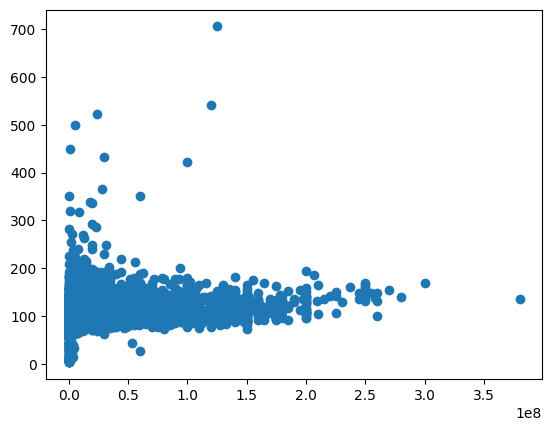

In [116]:
plt.scatter(revenue_budget_metadata_df[feature1], revenue_budget_metadata_df[feature2])
plt.show()

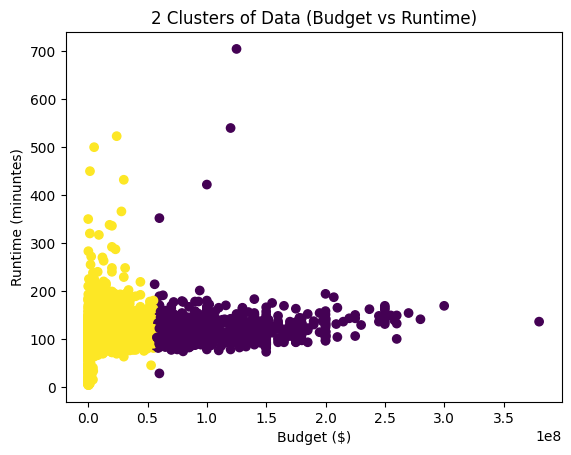

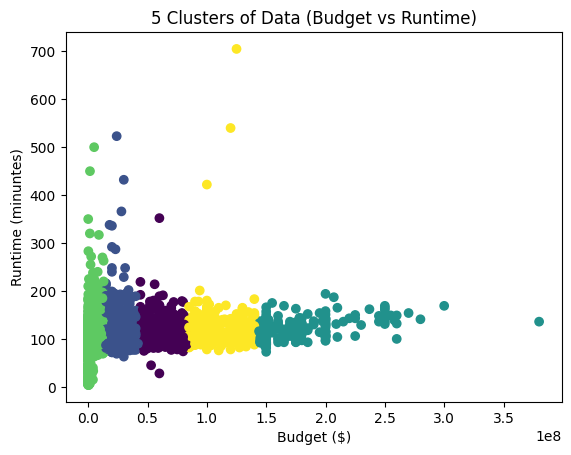

In [123]:
run_and_plot_minibatchkmeans(revenue_budget_metadata_df, [2, 5], ["budget", "$"], ["runtime", "minuntes"])

### Study 3 — Content-Based Recommendation System

### Study 4 — Collaborate Filtering Recommendation System

## Conclusion

## References